# Solving Function Optimization


The Rosenbrock function, also referred to as the Valley or Banana function, is a popular test problem for gradient-based optimization algorithms. It is shown in the plot above in its two-dimensional form.

Formula:  $f(x) = \sum_{i=1}^{n-1} (100 \times (x_{i+1}-x_i^2)^2 + (x_i-1)^2)$

For 2d function: $f(x,y) = 100 \times (y-x^2)^2 + (1-x)^2$

Dimensions: n

Input Domain: The function is usually evaluated on the hypercube $x_i \in [-5, 10]$ for all $i=1,...,n$. The domain may be restricted to  $x_i \in [-2.048, 2.048]$ for all $i=1,...,n$

Global Minimum: This function has global minimum at f(x*)= 0.0 located at (1,...,1).

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Define and visualize the Rosenbrock function

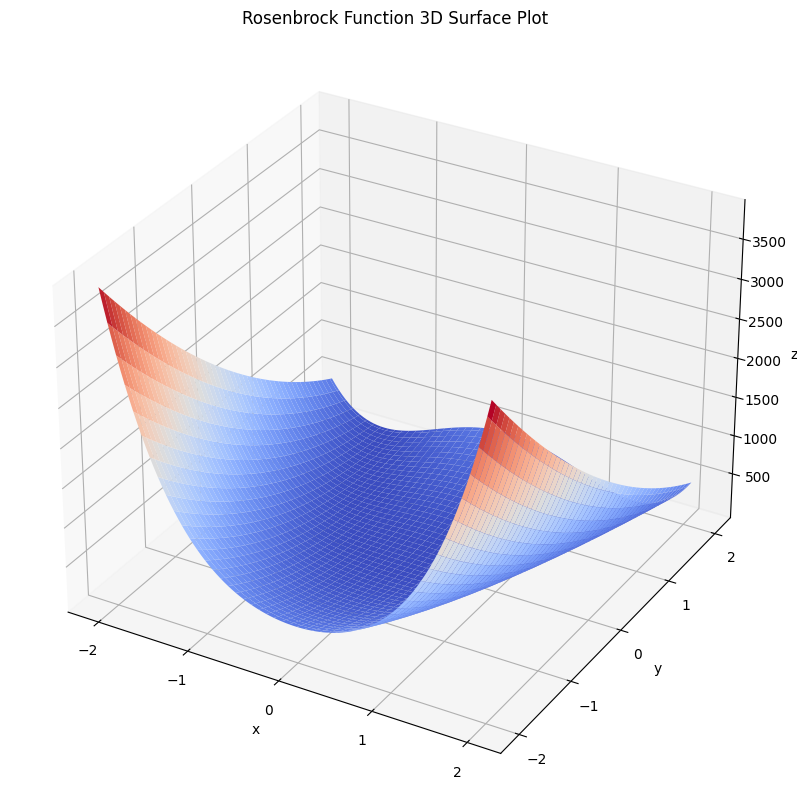

In [9]:
def rosenbrock_function(cand_soln):
    return (1 - cand_soln[0]) ** 2 + 100 * (cand_soln[1] - cand_soln[0] ** 2) ** 2

# Create a meshgrid of x and y values
x = np.linspace(-2.048, 2.048, 100)
y = np.linspace(-2.048, 2.048, 100)
X, Y = np.meshgrid(x, y)
X = np.array(X)
Y = np.array(Y)

# Calculate Rosenbrock function values for each point in the mesh grid
Z = np.array([[rosenbrock_function([x, y]) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
# Flatten Z to a 2D array
Z = Z.flatten().reshape(len(X), len(Y))

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rosenbrock Function 3D Surface Plot')

# # Create a 2D contour plot
# fig, ax = plt.subplots(figsize=(8, 8))
# contour = ax.contour(X, Y, Z, cmap='coolwarm')
# ax.clabel(contour, inline=True, fontsize=10)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Rosenbrock Function 2D Contour Plot')

plt.show()
# plt.savefig('CH10_F15_Rosenbrock.png', dpi=300)

# Solving Rosenbrock function using ABC

### Create ABC solver

In [3]:
class Bee:
    def __init__(self, position, fitness):
        self.position = position
        self.fitness = fitness
        self.counter = 0

def abc_algorithm(dimensions, num_bees, max_iter, max_trials):
    def generate_bee():
        position = np.array([random.uniform(-5, 5) for _ in range(dimensions)])
        fitness = rosenbrock_function(position)
        return Bee(position, fitness)

    def update_position(bee, partner):
        index = random.randrange(dimensions)
        phi = random.uniform(-1, 1)
        new_position = bee.position.copy()
        new_position[index] += phi * (bee.position[index] - partner.position[index])
        new_position = np.clip(new_position, -5, 5)
        new_fitness = rosenbrock_function(new_position)
        if new_fitness < bee.fitness:
            bee.position = new_position
            bee.fitness = new_fitness
            bee.counter = 0
        else:
            bee.counter += 1

    bees = [generate_bee() for _ in range(num_bees)]
    best_bee = min(bees, key=lambda bee: bee.fitness)

    for _ in range(max_iter):
        for i in range(num_bees // 2):
            employed_bee = bees[i]
            partner_bee = random.choice(bees)
            update_position(employed_bee, partner_bee)

        for i in range(num_bees // 2, num_bees):
            onlooker_bee = bees[i]
            partner_bee = min(bees[:num_bees // 2], key=lambda bee: bee.fitness)
            update_position(onlooker_bee, partner_bee)

        for bee in bees:
            if bee.counter > max_trials:
                new_bee = generate_bee()
                bee.position = new_bee.position
                bee.fitness = new_bee.fitness
                bee.counter = 0

        best_iter_bee = min(bees, key=lambda bee: bee.fitness)
        if best_iter_bee.fitness < best_bee.fitness:
            best_bee = best_iter_bee

    return best_bee

### Set up the solver and apply it to solve the problem

In [4]:
# Parameters
dimensions = 2
num_bees = 50
max_iter = 1000
max_trials = 100

# Run the ABC algorithm
best_bee = abc_algorithm(dimensions, num_bees, max_iter, max_trials)
print(f"Best solution: {best_bee.position}")
print(f"Best fitness: {best_bee.fitness}")

Best solution: [0.99437357 0.98875076]
Best fitness: 3.173532911200461e-05


# Solving Rosenbrock function using ACO

### Create ACO solver

In [5]:
class ACO:
    def __init__(self, ants, generations, lower_bound, upper_bound, phi, rho):
        self.ants = ants
        self.generations = generations
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.phi = phi
        self.rho = rho
        self.dim = len(lower_bound)
        self.sigma = (upper_bound - lower_bound) / 6

    def optimize(self):
        best_cost = float("inf")
        best_solution = None

        for gen in range(self.generations):
            for ant in range(self.ants):
                current_solution = np.random.uniform(self.lower_bound, self.upper_bound, self.dim)
                current_cost = rosenbrock_function(current_solution)

                if current_cost < best_cost:
                    best_cost = current_cost
                    best_solution = current_solution

                for i in range(self.dim):
                    mean = best_solution[i]
                    sd = self.sigma[i]

                    new_value = np.random.normal(mean, sd)
                    new_value = np.clip(new_value, self.lower_bound[i], self.upper_bound[i])
                    current_solution[i] = new_value

                self.sigma *= self.phi
                self.sigma = np.maximum(self.sigma, self.rho * (self.upper_bound - self.lower_bound))

        return best_solution, best_cost

### Set up the solver and apply it to solve the problem

In [6]:
ants = 50
generations = 100
lower_bound = np.array([-2.048, -2.048])
upper_bound = np.array([2.048, 2.048])
phi = 0.95
rho = 0.01

aco = ACO(ants, generations, lower_bound, upper_bound, phi, rho)
best_ant_soln, best_ant_cost = aco.optimize()

print(f"Best solution: {best_ant_soln}")
print(f"Cost at best solution: {best_ant_cost}")

Best solution: [1.04408399 1.07065605]
Cost at best solution: 0.0010290064960587707


## Visualize the solutions

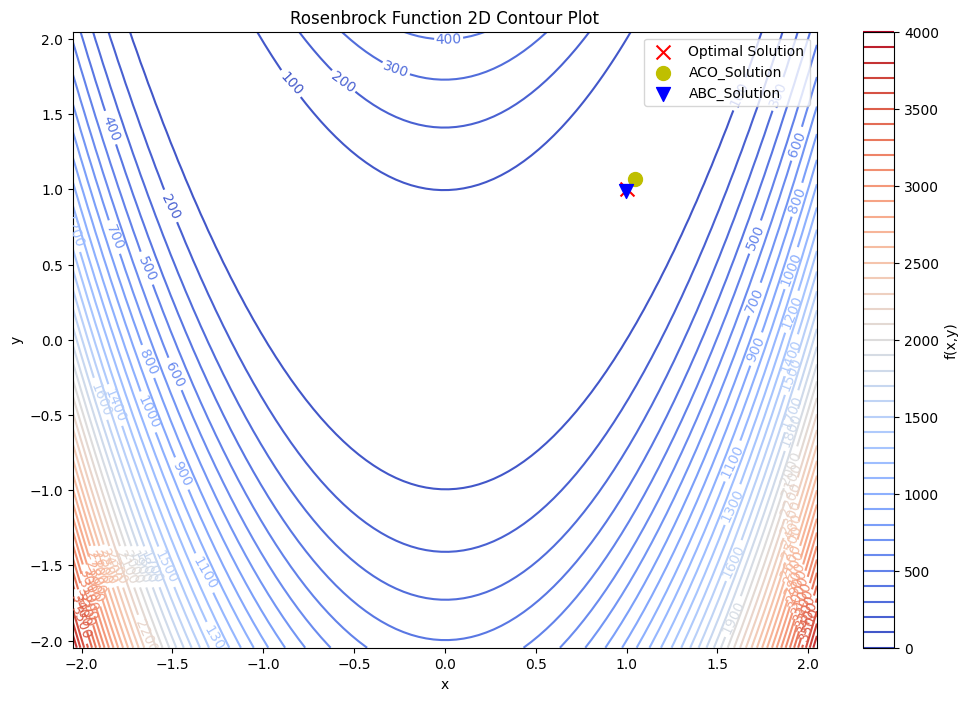

In [11]:
# Create a 2D contour plot
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contour(X, Y, Z, cmap='coolwarm', levels=40)
ax.scatter(1, 1, c='r', marker='x', s=100, label='Optimal Solution')
ax.scatter(best_ant_soln[0], best_ant_soln[1], c='y', marker='o', s=100, label='ACO_Solution')
ax.scatter(best_bee.position[0], best_bee.position[1], c='b', marker='v', s=100, label='ABC_Solution')
ax.clabel(contour, inline=True, fontsize=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Rosenbrock Function 2D Contour Plot')
ax.legend()
plt.colorbar(contour, label='f(x,y)')
plt.show()
# plt.savefig('CH10_F16_Rosenbrock_soln.png', dpi=300)